<a href="https://colab.research.google.com/github/Subinhyun/AI/blob/master/15weeks_Maze_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

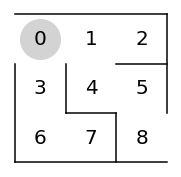

In [ ]:
# 미로 생성
fig = plt.figure(figsize=(3, 3))

# 벽
plt.plot([0, 3], [3, 3], color='k') # 상단 가로 벽
plt.plot([0, 3], [0, 0], color='k') # 하단 가로 벽
plt.plot([0, 0], [0, 2], color='k') # 왼쪽 벽
plt.plot([3, 3], [1, 3], color='k') # 오른쪽 벽
plt.plot([1, 1], [1, 2], color='k') # 3 오른쪽 벽
plt.plot([2, 3], [2, 2], color='k') # 2 아래쪽 벽
plt.plot([2, 1], [1, 1], color='k') # 4 아래쪽 벽
plt.plot([2, 2], [0, 1], color='k') # 7 오른쪽 벽

# 숫자
for i in range(3):
  for j in range(3):
    plt.text(0.5 + i, 2.5 - j, str(i + j *3), size=20, ha='center', va='center')

# 원: 시작 포인트를 표시
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

# 눈금 및 배경 숨김
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
plt.box(False)

plt.show()

In [ ]:
# 파라미터 θ의 초기값 준비
# 1: 이동할 수 있는 방향
# np.nan: 이동할 수 없는 방향
theta0 = np.array([
        [np.nan, 1, 1, np.nan], # 0 상, 우, 하, 좌
        [np.nan, 1, 1, 1], # 1
        [np.nan, np.nan, np.nan, 1], # 2
        [1, np.nan, 1, np.nan], # 3
        [1, 1, np.nan, np.nan], # 4
        [np.nan, np.nan, 1, 1], # 5
        [1, 1, np.nan, np.nan], # 6
        [np.nan, np.nan, np.nan, 1] # 7
])

In [ ]:
# 파라미터 θ의 정책으로 변환
# 정책 경사법에서는 '소프트맥스 함수'를 이용
# 소프트맥스 함수: 값의 합계가 1이 되도록 해당 값들을 0~1 사이의 실수값으로 변경
# [np.nan, 1, 1, np.nan] -> [0, 0.5, 0.5, 0]

def get_pi(theta):
  [m, n] = theta.shape
  pi = np.zeros((m, n))

  for i in range(0, m):
    pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
  
  pi = np.nan_to_num(pi)

  return pi


In [ ]:
# 파라미터 θ의 초기값을 정책으로 변환
pi = get_pi(theta0)
print(pi)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


In [ ]:
# 정책에 따라 행동 얻기
# np.random.choice(): 인수 p의 확률 분포에 따라 배열의 엘리먼트를 무작위로 반환
# 값이 [0, 1, 2, 3]이고, p가 [0., 0.5, 0.5, 0.]인 경우에는 50% 확률로 1 또는 2 반환

def get_a(pi, s):
  return np.random.choice([0, 1, 2 , 3], p=pi[s])

In [ ]:
# 행동에 따라 다음 상태 얻기

def get_s_next(s, a):
  if a == 0:
    return s-3
  if a == 1:
    return s+1
  if a == 2:
    return s+3
  if a == 3:
    return s-1


In [ ]:
# 1 에피소드 실행 후 이력 취득
# 이력은 [상태, 행동]의 리스트

def play(pi):
  s = 0
  s_a_history = [[0, np.nan]]

  #에피소드 종료까지 반복 
  while True:
    #정책에 따라 행동 얻기
    a = get_a(pi, s)
    #행동에 따라 다음 상태 계산
    s_next = get_s_next(s, a)
    #이력 갱신
    s_a_history[-1][1] = a
    s_a_history.append([s_next, np.nan])

    #종료
    if s_next == 8:
      break
    else:
      s = s_next
  return s_a_history

In [ ]:
# 1 에피소드 실행 및 이력 확인

s_a_history = play(pi)
print(s_a_history)
print('1 에피소드의 스텝 수: {}'.format(len(s_a_history)-1))

[[0, 1], [1, 3], [0, 1], [1, 2], [4, 0], [1, 2], [4, 0], [1, 1], [2, 3], [1, 3], [0, 2], [3, 0], [0, 2], [3, 0], [0, 1], [1, 2], [4, 1], [5, 2], [8, nan]]
1 에피소드의 스텝 수: 18


In [ ]:
# 파라미터 θ 갱신
def update_theta(theta, pi, s_a_history):
  eta = 0.1
  T = len(s_a_history)-1
  [s_count, a_count] = theta.shape

  delta_theta = theta.copy()
  for i in range(0, s_count):
    for j in range(0, a_count):
      if not(np.isnan(theta[i, j])):
        sa_ij = [sa for sa in s_a_history if sa == [i, j]]
        n_ij = len(sa_ij)
        sa_i = [sa for sa in s_a_history if sa[0] == i]
        n_i = len(sa_i)
        delta_theta[i, j] = (n_ij - pi[i, j] * n_i) / T
  return theta + eta * delta_theta

In [ ]:
# 에피소드를 반복해서 실행하며 학습하기
stop_epsilon = 10**-4
theta = theta0
pi = pi0


# 에피소드를 반복해서 실행하며 학습
for episode in range(10000):
  # 1 에피소드 실행 후 이력 얻기
  s_a_history = play(pi)
  # 파라미터 θ 갱신
  theta = update_theta(theta, pi, s_a_history)
  # 정책 갱신
  pi_new = get_pi(theta)
  # 정책 변화량
  pi_delta = np.sum(np.abs(pi_new - pi))
  pi = pi_new
  # 출력
  print('에피소드: {}, 스텝: {}, 정책 변화량: {:.4f}'.format(
      episode, len(s_a_history) -1, pi_delta))
  
  # 완료 판정: 정책 변화량이 임계값 이하일 때
  if pi_delta < stop_epsilon:
    break

에피소드: 0, 스텝: 136, 정책 변화량: 0.0130
에피소드: 1, 스텝: 86, 정책 변화량: 0.0092
에피소드: 2, 스텝: 76, 정책 변화량: 0.0104
에피소드: 3, 스텝: 10, 정책 변화량: 0.0294
에피소드: 4, 스텝: 10, 정책 변화량: 0.0294
에피소드: 5, 스텝: 16, 정책 변화량: 0.0181
에피소드: 6, 스텝: 12, 정책 변화량: 0.0325
에피소드: 7, 스텝: 12, 정책 변화량: 0.0204
에피소드: 8, 스텝: 32, 정책 변화량: 0.0091
에피소드: 9, 스텝: 42, 정책 변화량: 0.0138
에피소드: 10, 스텝: 20, 정책 변화량: 0.0146
에피소드: 11, 스텝: 18, 정책 변화량: 0.0114
에피소드: 12, 스텝: 36, 정책 변화량: 0.0106
에피소드: 13, 스텝: 92, 정책 변화량: 0.0099
에피소드: 14, 스텝: 32, 정책 변화량: 0.0142
에피소드: 15, 스텝: 98, 정책 변화량: 0.0088
에피소드: 16, 스텝: 6, 정책 변화량: 0.0316
에피소드: 17, 스텝: 54, 정책 변화량: 0.0113
에피소드: 18, 스텝: 74, 정책 변화량: 0.0087
에피소드: 19, 스텝: 152, 정책 변화량: 0.0067
에피소드: 20, 스텝: 18, 정책 변화량: 0.0154
에피소드: 21, 스텝: 14, 정책 변화량: 0.0123
에피소드: 22, 스텝: 24, 정책 변화량: 0.0209
에피소드: 23, 스텝: 22, 정책 변화량: 0.0112
에피소드: 24, 스텝: 58, 정책 변화량: 0.0116
에피소드: 25, 스텝: 14, 정책 변화량: 0.0182
에피소드: 26, 스텝: 16, 정책 변화량: 0.0231
에피소드: 27, 스텝: 10, 정책 변화량: 0.0199
에피소드: 28, 스텝: 38, 정책 변화량: 0.0133
에피소드: 29, 스텝: 18, 정책 변화량: 0.0150
에피소드: 30, 스텝: 68, 정

In [ ]:
print(theta)

[[           nan 1.99956436e+00 4.35635277e-04            nan]
 [           nan 1.43279701e-02 2.98394162e+00 1.73040657e-03]
 [           nan            nan            nan 1.00000000e+00]
 [1.31154693e+00            nan 6.88453073e-01            nan]
 [1.55650670e-04 1.99984435e+00            nan            nan]
 [           nan            nan 1.99982207e+00 1.77928915e-04]
 [1.07930559e+00 9.20694414e-01            nan            nan]
 [           nan            nan            nan 1.00000000e+00]]


In [ ]:
# 애니메이션 정기 처리를 수행하는 함수
def animate(i):
  state = s_a_history[i][0]
  circle.set_data((state % 3) + 0.5, 2.5 - int(state / 3))
  return circle

# 애니메이션 표시
anim = animation.FuncAnimation(fig, animate,
                frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())